<function matplotlib.pyplot.show(*args, **kw)>

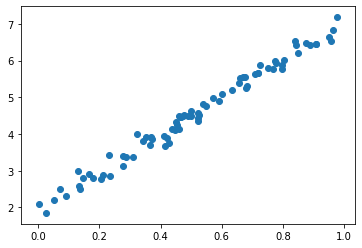

In [2]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(7)
x = np.random.rand(100, 1)
y = 2 + 5 * x + .2 * np.random.randn(100, 1)

idx = np.arange(100)
np.random.shuffle(idx)

train_idx = idx[:80]
val_idx = idx[80:]

x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

plt.scatter(x_train, y_train)
plt.show

In [3]:
np.random.seed(7)
a = np.random.randn(1)
b = np.random.randn(1)

lr = 1e-1
epochs = 2500

for epoch in range(epochs):
    yhat = a + b * x_train

    error = (y_train - yhat)
    loss = (error ** 2).mean()

    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()

    a = a - lr*a_grad
    b = b - lr*b_grad

print (a,b)

[1.94426643] [5.10697899]


In [4]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train, y_train)
print(LR.intercept_, LR.coef_[0])

[1.94426643] [5.10697899]


In [40]:
import torch
from torch import optim
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

torch.manual_seed(7)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
epochs = 2500

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(epochs):
    yhat = a + b * x_train_tensor
    
    #error = y_train_tensor - yhat
    #loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()

    #with torch.no_grad():
        #a -= lr * a.grad
        #b -= lr * b.grad
    optimizer.step()

    #a.grad.zero_()
    #b.grad.zero_()
    optimizer.zero_grad()

print(a, b)

tensor([-0.1468], requires_grad=True) tensor([0.7861], requires_grad=True)
tensor([1.9443], requires_grad=True) tensor([5.1070], requires_grad=True)


In [51]:
class PyTorchLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(7)
        self.a = nn.Parameter(torch.randn(1, requires_grad=True))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x):
        return self.a + self.b * x

class PyTorchLinearRegressionLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

#model = PyTorchLinearRegression()
#model = PyTorchLinearRegressionLayer()
model = nn.Sequential(nn.Linear(1, 1))

lr = 1e-1
epochs = 2500

MSELoss = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    yhat = model(x_train_tensor)

    loss = MSELoss(y_train_tensor, yhat)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('0.weight', tensor([[5.1070]])), ('0.bias', tensor([1.9443]))])


In [53]:
def build_train_step(model, loss_fn, optimizer):

    def train_step(x, y):
        model.train()

        yhat = model(x)

        loss = loss_fn(y, yhat)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        return loss.item()

    return train_step

train_step = build_train_step(model, MSELoss, optimizer)

for epoch in range(epochs):
    loss = train_step(x_train_tensor, y_train_tensor)

print(model.state_dict())

OrderedDict([('0.weight', tensor([[5.1070]])), ('0.bias', tensor([1.9443]))])


In [68]:
from torch.utils.data import Dataset, DataLoader

class SLRDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

training_data = SLRDataset(x_train_tensor, y_train_tensor)
print(training_data[0])

train_loader = DataLoader(dataset=training_data, batch_size=16, shuffle=True)

losses = []
train_step = build_train_step(model, MSELoss, optimizer)

for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        loss = train_step(x_batch, y_batch)
        losses.append(loss)

print(model.state_dict())
print(losses[-1])

(tensor([0.9501]), tensor([6.6368]))
OrderedDict([('0.weight', tensor([[5.1084]])), ('0.bias', tensor([1.9467]))])
0.01795516349375248


In [70]:
from torch.utils.data.dataset import random_split
from torch.utils.data import TensorDataset

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)